In [84]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os
from operator import itemgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import regex as rex
import math
from collections import defaultdict
from scipy import stats
import matplotlib.cm as cm

import csv

In [2]:
path = "/content/drive/MyDrive/output_attr_stats.csv"
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
path = "output_attr_stats.csv"

In [53]:
df = pd.read_csv(path)
df = df.iloc[0:2000]

In [54]:
def remove_outliers(df):
    #this takes in a dataframe and returns a dataframe with the word and character outliers taken out
    
    new_d = df.copy()   # shallow copy (NOT a deep copy)
    nb_char = df['nb_chars']
    nb_word = df['nb_words']
    nb_char_np = nb_char.to_numpy()
    nb_word_np = nb_word.to_numpy()
    
    std_mad_char = new_d.nb_chars.mad()
    std_mad_word = new_d.nb_words.mad()
    median_char = new_d.nb_chars.median()
    median_word = new_d.nb_words.median()
    
    check_char = nb_char < median_char + 3*std_mad_char
    check_word = nb_word < median_word + 3*std_mad_word
    
    new_d = new_d[check_char | check_word]
    return new_d

In [55]:
display(df)
for col in df.columns:
    print(col)

,filenm,From,Sent,To,CC,Bcc,Subject,Attachments,Importance,isThread,...,cc,nb_words,nb_chars,body_len,body,mn_nb_words,std_nb_words,mn_nb_chars,std_nb_chars,email_count
0,29142_fn_10-4-Cascade-2015-1-0_ln_42056.txt,shaneamoniz,"Friday, May 08, 2015 11:38 AM",brooks@culpeppercc.com,rgrindler@101tally.com;davidrosenfeld,NaN,Edison RFI's,RFI 008 Response.pdf; RFI 042 Response.pdf; RF...,NaN,False,...,Ryan Grindler rgrindler@101tally.com ; Rosenf...,55,338,392,"Response.pdf Brooks, attached is our response ...",196.566667,750.078234,1132.166667,4195.776753,30
1,41353_fn_10-3-Cascade-2014-2-0_ln_16811.txt,markbeaudoin,"Tuesday, August 19, 2014 5:21 PM",kristencoons,patrickhurley,NaN,RE: Revised lease,NaN,NaN,False,...,Patrick Hurley,3,9,11,Good by me!,155.288462,899.776839,818.348558,4797.418093,416
2,01216_fn_17-2-IB2013-1-0_ln_44062.txt,kenmorris,"Tuesday, May 28, 2013 1:22 PM",kim@inkbridge.com,deborahcraig;lindsayjordan;jessicamiller;jayto...,NaN,Proposed Imagine Schedule,NaN,NaN,False,...,Jon Brown; Mathieu Cavell; CMR_Team CMR_Team; ...,401,1928,2328,"Kim, See comments in blue regarding the propos...",483.698113,1078.306464,2747.301887,6354.713186,53
3,32414_fn_32-1-PaigeCS-1-1_ln_18843.txt,director@springtimetallahassee.com,"Wednesday, March 15, 2017 5:32 PM",alisonfaris,paigecarter;edwardkring;paradespringtimetallah...,NaN,RE: Springtime Parade,NaN,NaN,False,...,Paige Carter-Smith; Parade Springtime Tallahas...,279,1445,1723,"Hi Alison, Dont apologize, I know its a lot to...",372.461538,619.810941,1888.615385,3156.748922,13
4,56710_fn_31-2-GaryYordon2-3_ln_41027.txt,paullamaster,"Sunday, June 7, 2015 at 1:33:39 PM Eastern Day...",gil.ziffer@talgov.com;rick.fernandez@talgov.co...,gary@zprgroup.com,NaN,Tony Carvajal: Develop strategy to get ahead o...,NaN,NaN,False,...,alan.williams@myfloridahouse.gov; gary@zprgrou...,110,561,670,Highly recommend you take a moment out of your...,184.072937,127.504495,1288.858746,648.333393,3030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,33108_fn_9-2-Adam-Corey2013-1-0_ln_13380.txt,rickmccraw,"Wednesday, May 08, 2013 2:24 PM",genecrawford;jessejabot;dandonovan;steveshafer...,invalid_nan,NaN,RE: May 9th Meeting of the Kleman Plaza Design...,KPDRB November 8 2012_ DRAFT Minutes.pdf; KPDR...,NaN,False,...,INVALID_TYPE,103,595,697,DRAFT Minutes.pdf Dear Kleman Plaza Design Rev...,500.606061,1628.451088,2641.613054,8619.135153,429
1996,21584_fn_34-2-ScottMaddox2_ln_38388.txt,wade.bishop@talgov.com,"Tuesday, June 25, 2013 9:31 AM",invalid,invalid_nan,NaN,news clip,NaN,NaN,False,...,INVALID_TYPE,125,793,917,24June13wctv1 Starmetro & bicyclists-keeping b...,97.300613,60.763469,643.748466,357.386956,163
1997,14092_fn_23-6-PaigeCarter-Smith2017-2-0_ln_367...,timlee,"Monday, February 20, 2017 2:53 PM",allmailboxes,invalid_nan,NaN,Email Spam,NaN,NaN,False,...,INVALID_TYPE,1,0,0,NaN,124.463087,135.107441,639.395973,690.248788,149
1998,51906_fn_34-5-ScottMaddox5_ln_59547.txt,allison.fleming@talgov.com,"Tuesday, October 15, 2013 11:38 AM",carriehughes,invalid_nan,NaN,Accepted: Commissioner Briefing - Evening Ros...,NaN,NaN,False,...,INVALID_TYPE,1,0,0,NaN,56.192571,72.060620,310.296188,370.403156,1023


filenm
From
Sent
To
CC
Bcc
Subject
Attachments
Importance
isThread
isAutoMessage
isDisplacement
hasAllCapLine
hasBadDate
Body
timestamp
date_sent
time_sent
cc
nb_words
nb_chars
body_len
body
mn_nb_words
std_nb_words
mn_nb_chars
std_nb_chars
email_count


In [79]:
def add_To_CC_num(df):
  #takes in a dataframe and returns a dataframe that has 
  #two new columns: number of people sent in To and number of people sent in CC
  # Create two new columns: number of elements in To and number of elements in Cc
  num_to = []
  num_cc = []
  for i in range(len(df)):
    print(i)
    e = df.iloc[[i]]
    to = str(e['To'])
    cc = str(e['CC'])
    result_to = to.split(';')
    result_cc = cc.split(';')
    num_to.append(len(result_to))
    num_cc.append(len(result_cc))
  dd = df.copy()
  dd['num_To'] = num_to
  dd['num_CC'] = num_cc
  return dd


In [80]:
def new_add_To_CC_num(df):
  """
  # Add two columns to dataframe: number of elements in To: and nb elements in CC:
  
  Arguments
  ---------
      df (DataFrame)
          Initial dataframe
  
  Return
  -------
  dd (DataFrame)
      Original dataframe with two additional columns
  """

  dd = df.copy()
  to_list = []
  cc_list = []

  for el in df.To:
    split = el.split(";")
    to_list.append(len(split))
    
  for el in df.CC:
    split = el.split(";")
    if len(split) <= 0: 
        continue
    cc_list.append(len(split))
    
  dd['num_To'] = to_list
  dd['num_CC'] = cc_list
  return dd


In [58]:
df2 = new_add_To_CC_num(df)

In [59]:
df2.columns

Index(['filenm', 'From', 'Sent', 'To', 'CC', 'Bcc', 'Subject', 'Attachments',
       'Importance', 'isThread', 'isAutoMessage', 'isDisplacement',
       'hasAllCapLine', 'hasBadDate', 'Body', 'timestamp', 'date_sent',
       'time_sent', 'cc', 'nb_words', 'nb_chars', 'body_len', 'body',
       'mn_nb_words', 'std_nb_words', 'mn_nb_chars', 'std_nb_chars',
       'email_count', 'num_To', 'num_CC'],
      dtype='object')

In [60]:
display(df)

,filenm,From,Sent,To,CC,Bcc,Subject,Attachments,Importance,isThread,...,cc,nb_words,nb_chars,body_len,body,mn_nb_words,std_nb_words,mn_nb_chars,std_nb_chars,email_count
0,29142_fn_10-4-Cascade-2015-1-0_ln_42056.txt,shaneamoniz,"Friday, May 08, 2015 11:38 AM",brooks@culpeppercc.com,rgrindler@101tally.com;davidrosenfeld,NaN,Edison RFI's,RFI 008 Response.pdf; RFI 042 Response.pdf; RF...,NaN,False,...,Ryan Grindler rgrindler@101tally.com ; Rosenf...,55,338,392,"Response.pdf Brooks, attached is our response ...",196.566667,750.078234,1132.166667,4195.776753,30
1,41353_fn_10-3-Cascade-2014-2-0_ln_16811.txt,markbeaudoin,"Tuesday, August 19, 2014 5:21 PM",kristencoons,patrickhurley,NaN,RE: Revised lease,NaN,NaN,False,...,Patrick Hurley,3,9,11,Good by me!,155.288462,899.776839,818.348558,4797.418093,416
2,01216_fn_17-2-IB2013-1-0_ln_44062.txt,kenmorris,"Tuesday, May 28, 2013 1:22 PM",kim@inkbridge.com,deborahcraig;lindsayjordan;jessicamiller;jayto...,NaN,Proposed Imagine Schedule,NaN,NaN,False,...,Jon Brown; Mathieu Cavell; CMR_Team CMR_Team; ...,401,1928,2328,"Kim, See comments in blue regarding the propos...",483.698113,1078.306464,2747.301887,6354.713186,53
3,32414_fn_32-1-PaigeCS-1-1_ln_18843.txt,director@springtimetallahassee.com,"Wednesday, March 15, 2017 5:32 PM",alisonfaris,paigecarter;edwardkring;paradespringtimetallah...,NaN,RE: Springtime Parade,NaN,NaN,False,...,Paige Carter-Smith; Parade Springtime Tallahas...,279,1445,1723,"Hi Alison, Dont apologize, I know its a lot to...",372.461538,619.810941,1888.615385,3156.748922,13
4,56710_fn_31-2-GaryYordon2-3_ln_41027.txt,paullamaster,"Sunday, June 7, 2015 at 1:33:39 PM Eastern Day...",gil.ziffer@talgov.com;rick.fernandez@talgov.co...,gary@zprgroup.com,NaN,Tony Carvajal: Develop strategy to get ahead o...,NaN,NaN,False,...,alan.williams@myfloridahouse.gov; gary@zprgrou...,110,561,670,Highly recommend you take a moment out of your...,184.072937,127.504495,1288.858746,648.333393,3030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,33108_fn_9-2-Adam-Corey2013-1-0_ln_13380.txt,rickmccraw,"Wednesday, May 08, 2013 2:24 PM",genecrawford;jessejabot;dandonovan;steveshafer...,invalid_nan,NaN,RE: May 9th Meeting of the Kleman Plaza Design...,KPDRB November 8 2012_ DRAFT Minutes.pdf; KPDR...,NaN,False,...,INVALID_TYPE,103,595,697,DRAFT Minutes.pdf Dear Kleman Plaza Design Rev...,500.606061,1628.451088,2641.613054,8619.135153,429
1996,21584_fn_34-2-ScottMaddox2_ln_38388.txt,wade.bishop@talgov.com,"Tuesday, June 25, 2013 9:31 AM",invalid,invalid_nan,NaN,news clip,NaN,NaN,False,...,INVALID_TYPE,125,793,917,24June13wctv1 Starmetro & bicyclists-keeping b...,97.300613,60.763469,643.748466,357.386956,163
1997,14092_fn_23-6-PaigeCarter-Smith2017-2-0_ln_367...,timlee,"Monday, February 20, 2017 2:53 PM",allmailboxes,invalid_nan,NaN,Email Spam,NaN,NaN,False,...,INVALID_TYPE,1,0,0,NaN,124.463087,135.107441,639.395973,690.248788,149
1998,51906_fn_34-5-ScottMaddox5_ln_59547.txt,allison.fleming@talgov.com,"Tuesday, October 15, 2013 11:38 AM",carriehughes,invalid_nan,NaN,Accepted: Commissioner Briefing - Evening Ros...,NaN,NaN,False,...,INVALID_TYPE,1,0,0,NaN,56.192571,72.060620,310.296188,370.403156,1023


In [61]:
df_test = df2.iloc[0:2000]
display(df_test)
display(df_test.index)

,filenm,From,Sent,To,CC,Bcc,Subject,Attachments,Importance,isThread,...,nb_chars,body_len,body,mn_nb_words,std_nb_words,mn_nb_chars,std_nb_chars,email_count,num_To,num_CC
0,29142_fn_10-4-Cascade-2015-1-0_ln_42056.txt,shaneamoniz,"Friday, May 08, 2015 11:38 AM",brooks@culpeppercc.com,rgrindler@101tally.com;davidrosenfeld,NaN,Edison RFI's,RFI 008 Response.pdf; RFI 042 Response.pdf; RF...,NaN,False,...,338,392,"Response.pdf Brooks, attached is our response ...",196.566667,750.078234,1132.166667,4195.776753,30,1,2
1,41353_fn_10-3-Cascade-2014-2-0_ln_16811.txt,markbeaudoin,"Tuesday, August 19, 2014 5:21 PM",kristencoons,patrickhurley,NaN,RE: Revised lease,NaN,NaN,False,...,9,11,Good by me!,155.288462,899.776839,818.348558,4797.418093,416,1,1
2,01216_fn_17-2-IB2013-1-0_ln_44062.txt,kenmorris,"Tuesday, May 28, 2013 1:22 PM",kim@inkbridge.com,deborahcraig;lindsayjordan;jessicamiller;jayto...,NaN,Proposed Imagine Schedule,NaN,NaN,False,...,1928,2328,"Kim, See comments in blue regarding the propos...",483.698113,1078.306464,2747.301887,6354.713186,53,1,10
3,32414_fn_32-1-PaigeCS-1-1_ln_18843.txt,director@springtimetallahassee.com,"Wednesday, March 15, 2017 5:32 PM",alisonfaris,paigecarter;edwardkring;paradespringtimetallah...,NaN,RE: Springtime Parade,NaN,NaN,False,...,1445,1723,"Hi Alison, Dont apologize, I know its a lot to...",372.461538,619.810941,1888.615385,3156.748922,13,1,3
4,56710_fn_31-2-GaryYordon2-3_ln_41027.txt,paullamaster,"Sunday, June 7, 2015 at 1:33:39 PM Eastern Day...",gil.ziffer@talgov.com;rick.fernandez@talgov.co...,gary@zprgroup.com,NaN,Tony Carvajal: Develop strategy to get ahead o...,NaN,NaN,False,...,561,670,Highly recommend you take a moment out of your...,184.072937,127.504495,1288.858746,648.333393,3030,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,33108_fn_9-2-Adam-Corey2013-1-0_ln_13380.txt,rickmccraw,"Wednesday, May 08, 2013 2:24 PM",genecrawford;jessejabot;dandonovan;steveshafer...,invalid_nan,NaN,RE: May 9th Meeting of the Kleman Plaza Design...,KPDRB November 8 2012_ DRAFT Minutes.pdf; KPDR...,NaN,False,...,595,697,DRAFT Minutes.pdf Dear Kleman Plaza Design Rev...,500.606061,1628.451088,2641.613054,8619.135153,429,20,1
1996,21584_fn_34-2-ScottMaddox2_ln_38388.txt,wade.bishop@talgov.com,"Tuesday, June 25, 2013 9:31 AM",invalid,invalid_nan,NaN,news clip,NaN,NaN,False,...,793,917,24June13wctv1 Starmetro & bicyclists-keeping b...,97.300613,60.763469,643.748466,357.386956,163,1,1
1997,14092_fn_23-6-PaigeCarter-Smith2017-2-0_ln_367...,timlee,"Monday, February 20, 2017 2:53 PM",allmailboxes,invalid_nan,NaN,Email Spam,NaN,NaN,False,...,0,0,NaN,124.463087,135.107441,639.395973,690.248788,149,1,1
1998,51906_fn_34-5-ScottMaddox5_ln_59547.txt,allison.fleming@talgov.com,"Tuesday, October 15, 2013 11:38 AM",carriehughes,invalid_nan,NaN,Accepted: Commissioner Briefing - Evening Ros...,NaN,NaN,False,...,0,0,NaN,56.192571,72.060620,310.296188,370.403156,1023,1,1


RangeIndex(start=0, stop=2000, step=1)

In [81]:
def create_node_list(df):
  #this takes in a pandas dataframe
  
  to_list = []
  from_list = []
  CC_list = []

  alist = df['To']
#this gets all of the values under To for the df 

  for x in alist:# this interates through the values for To and
    result = x.split(';')#appends all of the values in it that are contained in ()
    for s in result:
      if '@' in s:
        to_list.append(s)


  blist = df['From']#the same that is done for To is done for From  and CC

  for x in blist:
    result = x.split(';')
    for s in result:
      if '@' in s:
        from_list.append(s)


  clist = df['CC']

  for x in clist:
    result = x.split(';')
    for s in result:
      if '@' in s:
        CC_list.append(s)

  final_list = to_list + from_list + CC_list #The lists are combined together

  Myfinallist = sorted(set(final_list)) #this takes out any repeating values

  return Myfinallist #returns a list of str

In [102]:
def new_create_node_list(df):
  #this takes in a pandas dataframe and returns a list of node names
  # the node names are either names or emails
  # Invalid nodes should be removed (NOT YET DONE)
  
  to_list = df.To.values
  cc_list = df.CC.values
  from_list = df.From.values
  node_set = set()
  
  for el in from_list:
        node_set.add(el)
        
  for els in to_list:
    split = els.split(";")
    for el in split:
        node_set.add(el)
    
  for els in cc_list:
    split = els.split(";")
    for el in split:
        node_set.add(el)
        
  # Remove non-strings
  node_list = []
  for n in node_set:
    if type(n) == str:  # NaN is a float
        if rex.match(r'.*invalid', n.lower()): continue
        if rex.match(r'.*@', n):
            node_list.append(n)
        
  node_list.sort()

  return node_list #returns a list of str

In [82]:
def create_edge_list(df, nodes):
  #takes in a dataframe and a list of str
  #df is supposed to be the email dataset and nodes is the nodes generated from the dataset
  edgelist = set()
  #creates a set so that there are only unique edges
  #maybe in the future it can account for multiple edges
  
  for node in nodes:
    #it goes through the nodes and gets all of the emails that were sent from that node
    if node != '':
      from_who = df.loc[df['From'] == node]
      r = len(from_who.index)

      for i in range(r):
        #iterates through all of the emails that were sent from a particular node
        #and saves all of the values encased in () and appends it to the edge list
        j = from_who.iloc[i:i+1]
        x = j['To']
        y = j['CC']
        #display(x)
        #display('-----')
        index_1 = nodes.index(node)
        for xi in x:
          #display(xi)
          #goes through the values in To and adds it to the edge list 
          if xi != '':
            result = re.findall('\(.*?\)', xi)
            for s in result:
              if s in nodes:
                index_2 = nodes.index(s)
                edgelist.add(tuple([index_1, index_2]))
        
        for yi in y:
          #this is done for CC as well as From
          if yi != '':
            result = re.findall('\(.*?\)', yi)
            for s in result:
              if s in nodes:
                index_2 = nodes.index(s)
                edgelist.add(tuple([index_1, index_2]))
        
  #this returns an edge list where the index is formatted [sender, reciever]
  return list(edgelist)

In [104]:
def new_create_edge_list(df, nodes):
  #takes in a dataframe and a list of str
  #df is supposed to be the email dataset and nodes is the nodes generated from the dataset
  edgelist = []
  #creates a set so that there are only unique edges
  #maybe in the future it can account for multiple edges
 
  from_list = df.From
  to_list = df.To
  cc_list = df.CC
   
  for f,to,cc in zip(df.From, df.To, df.CC):
     # Unique list of names
     if type(f) != str: continue
     receiver_list = list(set(to.split(";") + cc.split(";")))
     for rec in receiver_list:
        if type(rec) != str: continue
        if rex.match(r'.*invalid', rec.lower()): continue
        if ('@' in f) & ('@' in rec):
          edgelist.append((f, rec))
       
  return edgelist

In [105]:
def create_num_edgelist(nodes, edges):
  #takes in the nodes and the edges based on emails
  #and returns and edgelist that is based on the index of the email in nodes
  edge_list = []
  for i in range(len(edges)):
    e1 = nodes.index(edges[i][0])
    e2 = nodes.index(edges[i][1])
    edge_list.append((e1,e2))
  return edge_list

In [85]:
def get_rid_of_NaN(val):
  #takes in a value and if it is Nan it returns 0
  if math.isnan(val):
    return 0
  return val
  
def get_rid_of_emp_str(s):
  #takes in a string and if it is '' it returns 0 otherwise it returns the length of the string
  if s == '':
    return 0
  else:
    return len(s)

In [86]:
df.columns

Index(['filenm', 'From', 'Sent', 'To', 'CC', 'Bcc', 'Subject', 'Attachments',
       'Importance', 'isThread', 'isAutoMessage', 'isDisplacement',
       'hasAllCapLine', 'hasBadDate', 'Body', 'timestamp', 'date_sent',
       'time_sent', 'cc', 'nb_words', 'nb_chars', 'body_len', 'body',
       'mn_nb_words', 'std_nb_words', 'mn_nb_chars', 'std_nb_chars',
       'email_count'],
      dtype='object')

In [87]:
#this is a rewrite with new column val

def create_node_meta_list(df, nodes):
  """
  What does this function do? 
  
  Arguments
  ---------
  df (DataFrame)
  nodes (list of str)
  
  Return
  ------
  Return new attributes
  """
  mean_char_list = []
  mean_word_list = []
  mean_to_list = []
  mean_cc_list = []
  std_char_list = []
  std_word_list = []
  std_to_list = []
  std_cc_list = []
  num_sent_list = []
  node_meta_list = []
  for node in nodes:
    to_data = []
    cc_data = []
    char_data = []
    word_data = []

    from_who = df.loc[df['From'] == node]
    to_who = df.loc[df['To'] == node]
    cc_who = df.loc[df['CC'] == node]

    num_recieved = len(to_who) + len(cc_who)

    num_sent = len(from_who)

    r = len(from_who.index)
    for i in range(r):
        #iterates through all of the emails that were sent from a particular node
        #and saves all of the values encased in () and appends it to the edge list
      j = from_who.iloc[i:i+1]
      #display(j)
      to_data.append(int(j['num_To']))
      cc_data.append(int(j['num_CC']))
      char_data.append(int(j['nb_chars']))
      word_data.append(int(j['nb_words']))


      
    char_data = np.array(char_data)
    word_data = np.array(word_data)

    to_data = np.array(to_data)
    cc_data = np.array(cc_data)

    mean_char = np.mean(char_data)
    mean_word = np.mean(word_data)

    std_char = np.std(char_data)
    std_word = np.std(word_data)

    mean_to = np.mean(to_data)
    mean_cc = np.mean(cc_data)

    std_to = np.std(to_data)
    std_cc = np.std(cc_data)

    mean_char = get_rid_of_NaN(mean_char)
    mean_word = get_rid_of_NaN(mean_word)
    mean_to = get_rid_of_NaN(mean_to)
    mean_cc = get_rid_of_NaN(mean_cc)
    std_char = get_rid_of_NaN(std_char)
    std_word = get_rid_of_NaN(std_word)
    std_to = get_rid_of_NaN(std_to)
    std_cc = get_rid_of_NaN(std_cc)

    inloop_node_meta = [mean_char, mean_word, mean_to, mean_cc, std_char, std_word, std_to, std_cc, num_sent]

    mean_char_list.append(mean_char)
    mean_word_list.append(mean_word)
    mean_to_list.append(mean_to)
    mean_cc_list.append(mean_cc)
    std_char_list.append(std_char)
    std_word_list.append(std_word)
    std_to_list.append(std_to)
    std_cc_list.append(std_cc)
    num_sent_list.append(num_sent)

    node_meta_list.append(inloop_node_meta)
  return [mean_char_list, mean_word_list, mean_to_list, mean_cc_list, std_char_list, std_word_list, std_to_list, std_cc_list, num_sent_list]

In [88]:
def get_node_recieved_list(df, nodes):
  # This takes in a dataframe and a node list and creates a list of the amount of emails a given node has received
  recieved_email = []
  for node in nodes: 
    alist = df['To']
    blist = df['CC']
    rec_num = 0

    for x in alist:
      result = x.split(';')
      if node in result:
        rec_num += 1

    for x in blist:
      result = x.split(';')
      if node in result:
        rec_num += 1

    recieved_email.append(rec_num)
  return recieved_email

In [89]:
def scale_meta(meta):
  #this takes in the feature matrix and scales the values based on the maximum number for each attribute
  scaled_meta = []
  for col in range(len(meta)):
    x = np.array(meta[col])
    max = np.amax(x)
    scaled_meta.append(x/max)
  return scaled_meta


In [90]:
def create_bi_class(df, node_meta):
# def create_labels(df, node_meta):
  """
  Create node labels
  
  Arguments
  ---------
  df (DataFrame), not used
  node_meta (list)
  
  Return
  -------
    bi_class (list)
        list of labels
  """
  bi_class = []
  mean_list = np.array(node_meta)
  mean_val = np.mean(mean_list)
  bi_class = list(node > mean_val)
  print(bi_class[0:100])
    
  #for node in node_meta:
    #if node > mean_val:
      #bi_class.append(1)
    #else:
      #bi_class.append(0)
  return bi_class

In [91]:
def create_node_list_txt(node, node_meta, rec_list, bi_class_list):
  #takes a list that has the node list, the sent list, and the recieved list
  #this is a new version of create_nodes_txt that incorporates the node metadata
  torch.manual_seed(0)
  with open('nodes.txt','w') as f:
    for i in range(len(node)):
      #display(node)
      X_str = ' '.join([str(element.item()) for element in .5 + torch.randn((16))])
      s = ''
      for n in range(len(node_meta[0])):
        s = s + str(node_meta[i][n]) + ' '
      #f.write( str(nodes[0][i]) + ' ' + s + X_str +'\n')
      f.write(str(i) + ' ' + str(bi_class_list[i]) + ' ' + s + str(rec_list[i]) + '\n')

In [92]:
def create_edges_txt(edges):
  #creates a txt file that is just the edge list
  with open('edges.txt','w') as f:
    for edge in edges:
      f.write(f'{edge[0]} {edge[1]} {1}\n')
      #print(edge[0])

In [99]:
def remove_outliers(df):
    # Rewritten by G. Erlebacher
    #new_d = df ### BAD
    new_d = df.copy()
    nb_char = df['nb_chars']
    nb_word = df['nb_words']
    nb_char_np = nb_char.to_numpy()
    nb_word_np = nb_word.to_numpy()
    
    mad_char = nb_char.median()
    mad_word = nb_word.median()
    std_char = nb_char.mad()
    std_word = nb_word.mad()
    
    check_char = nb_char < (mad_char + 3*std_char)
    check_word = nb_word < (mad_word + 3*std_word)
    new_d = new_d[check_char & check_word]
    return new_d

In [106]:
df_test_wo_outliers = remove_outliers(df_test)

In [113]:
df_nodes_test = new_create_node_list(df_test_wo_outliers)
df_edges_test = new_create_edge_list(df_test_wo_outliers, df_nodes_test)
df_edges_test = create_num_edgelist(df_nodes_test,df_edges_test)
df_edges_test;

# need a dictionary: index => email and email => index

In [115]:
df_node_meta_test = create_node_meta_list(df_test, df_nodes_test)

/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [121]:
len(df_node_meta_test[0]), len(df_nodes_test)

(4031, 4031)

In [157]:
from collections import defaultdict

def which_received(df, nodes):
    """
    Arguments
    ---------
    
    Return
    ------
    
    """
    df1 = df.copy()
    num_received = defaultdict(int)
    for frm,to_lst,cc_lst in zip(df.From, df.To, df.CC):
        if rex.match(r'.*invalid', frm.lower()): continue
        if '@' not in frm: continue
        to_split = to_lst.split(";")
        cc_split = cc_lst.split(";")
        # Assume that there are no common names between To: and CC: in a given mail
        for to in to_split:
            if rex.match(r'.*invalid', to.lower()): continue
            if '@' in to:
                num_received[to] += 1
        for cc in cc_split:
            if rex.match(r'.*invalid', cc.lower()): continue
            if '@' in cc:
                num_received[cc] += 1
                
    rec_list = []
    for el in nodes:
        rec_list.append(num_received[el])
        
    return rec_list

In [159]:
nb_rec = which_received(df_test, df_nodes_test)
list(rec.keys())[0:5]

# rec has no keys. THAT MUST BE AN ERROR

['jt@inkbridge.com',
 'gary@zprgroup.com',
 'sschimpf@megas.net',
 'ladyjacket832000@yahoo.com>',
 'kim@inkbridge.com']

In [150]:
d

0                              shaneamoniz
1                             markbeaudoin
2                                kenmorris
3       director@springtimetallahassee.com
4                             paullamaster
                       ...                
1995                            rickmccraw
1996                wade.bishop@talgov.com
1997                                timlee
1998            allison.fleming@talgov.com
1999              amayfield@mayfieldpr.com
Name: From, Length: 2000, dtype: object

In [ ]:
df_node_meta_test.append(df_rec_list_test)

In [ ]:
scaled_df_node_meta_test = scale_meta(df_node_meta_test)

/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [160]:
bi_classes_test = []
bi_classes_test_scaled = []
for i in range(len(df_node_meta_test)):
  bi_classes_test.append(create_bi_class(df_test, df_node_meta_test[i]))
  bi_classes_test_scaled.append(create_bi_class(df_test, scaled_df_node_meta_test[i]))

NameError: name 'node' is not defined

In [110]:
df_nodes_test_wo_outliers = create_node_list(df_test_wo_outliers)
df_edges_test_wo_outliers = new_create_edge_list(df_test_wo_outliers, df_nodes_test_wo_outliers)
df_edges_test_wo_outliers = create_num_edgelist(df_nodes_test_wo_outliers, df_edges_test_wo_outliers)
df_node_meta_test_wo_outliers = create_node_meta_list(df_test_wo_outliers, df_nodes_test_wo_outliers)
df_rec_list_test_wo_outliers = get_node_recieved_list(df_test_wo_outliers, df_nodes_test_wo_outliers)
df_node_meta_test_wo_outliers.append(df_rec_list_test_wo_outliers)


scaled_df_node_meta_test_wo_outliers = scale_meta(df_node_meta_test_wo_outliers)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [111]:
bi_classes_test_wo_outliers = []
bi_classes_test_wo_outliers_scaled = []
for i in range(len(df_node_meta_test_wo_outliers)):
  bi_classes_test_wo_outliers.append(create_bi_class(df_test_wo_outliers, df_node_meta_test_wo_outliers[i]))
  bi_classes_test_wo_outliers_scaled.append(create_bi_class(df_test_wo_outliers, scaled_df_node_meta_test_wo_outliers[i]))

In [112]:
def create_node_list_txt(node, node_meta, bi_class_list):
  #takes a list that has the node list, the sent list, and the recieved list
  #this is a new version of create_nodes_txt that incorporates the node metadata
  torch.manual_seed(0)
  with open('nodes.txt','w') as f:
    for i in range(len(node)):
      s = ''
      for n in range(len(node_meta)):
        s = s + str(node_meta[n][i]) + ' '
      f.write(str(i) + ' ' + str(bi_class_list[i]) + ' ' + s + '\n')

In [113]:
def print_acc(predictions, bi_class):
  #This takes in two arrays and returns the percentage of how much they match
  x = 0
  for i in range(len(bi_class)):
    if predictions.argmax(dim=1)[i] == bi_class[i]:
      x += 1
  acc = 100 * x / len(bi_class) 
  display(acc)
  return acc

In [114]:
### A simple Message-Passing network w/ common aggregation schemes.
class Simple_GNN(torch.nn.Module):

    def __init__(self,in_features,int_features,out_features,depth,aggregation_mode = 'mean',dropout_prob = .1):
        '''
        [in_features]       - # of input features.
        [int_features]      - # of features in message-passing layers. Within the 
                              GNN literature, this is typically a constant.
        [out_features]      - # of output features. Corresponds to # of classes,
                              regression targets, etc.
        [depth]             - # of message-passing layers. 
        [aggregation_mode]  - choice of aggregation scheme. Can be 'mean',
                              'sum', 'max', or 'none'
        [dropout_prob]      - probability used for Dropout (see Srivastava et al., 2017)
        '''

        super(Simple_GNN,self).__init__()
        assert aggregation_mode in ['mean','sum','max','none']

        self.f_in = torch.nn.Linear(in_features,int_features)
        self.f_int = torch.nn.ModuleList([torch.nn.Sequential(*[torch.nn.Linear(int_features,int_features),
                                                                torch.nn.LeakyReLU(),
                                                                torch.nn.Dropout(dropout_prob)])
                                              for _ in range(depth)])
        self.f_out = torch.nn.Linear(int_features,out_features)

        if aggregation_mode == 'mean': self.agg = torch_scatter.scatter_mean
        elif aggregation_mode == 'sum': self.agg = torch_scatter.scatter_sum
        elif aggregation_mode == 'max': self.agg = torch_scatter.scatter_max

        self.aggregation_mode = aggregation_mode

    def forward(self,node_features,edge_index,edge_weights = None):
        '''
        [node_features]  - Matrix of node features. First (batch) dimension corresponds
                           to nodes; second to features.
        [edge_index]     - Edge list representation of a graph. Shape [num_edges]x2
        [edge_weights]   - Optional scalar edge weights. Shape [num_edges,1]
        '''

        node_features = self.f_in(node_features)
        for idx,layer in enumerate(self.f_int):
            if self.aggregation_mode != 'none':
                if edge_weights != None:
                    #display('here')
                    qqq = edge_weights * node_features[edge_index[:,0]]
                    qqq2 = edge_index[:,1]
                    
                    #display(len(edge_weights * node_features[edge_index[:,0]]))
                    #display(len(edge_index[:,1]))
                    #display(len(torch_scatter.scatter_mean(edge_weights * node_features[edge_index[:,0]],edge_index[:,1],dim=0)))


                    #this part right here is where the errors come from
                    #the output is supposed to be equal to the number of nodes which in this case is 4571 but it returns 4569
                    #when I do aggregation with the without outliers set that has less nodes it's still exactly 2 less
                    
                    aggregated_node_features = self.agg(edge_weights * node_features[edge_index[:,0]],
                                                                    edge_index[:,1],dim=0)
                    
                else:
                    aggregated_node_features = self.agg(node_features[edge_index[:,0]],edge_index[:,1],dim=0) 
            else:
                aggregated_node_features = node_features
                
            if isinstance(aggregated_node_features,tuple): 
                #display('here2')
                aggregated_node_features = aggregated_node_features[0]

            #display(len(node_features))
            #display(len(layer(aggregated_node_features)))
            #display(len(aggregated_node_features))

            node_features = node_features + layer(aggregated_node_features)
        return self.f_out(node_features),node_features

In [115]:
### General purpose object for storing graph data
class Graph(object):
    def __init__(self,edge_index = None,edge_metadata = None,node_metadata = None):
        self.edge_index = edge_index
        self.edge_metadata = edge_metadata
        self.node_metadata = node_metadata
        self.num_nodes = None

    def read_edges(self,filepath):
        ''' Edges should be stored as follows:
            0 1 3.1 2.0
            0 2 1.0 0.0
            1 0 3.1 2.0
            ...
        where the first two columns are node indices and the remainder
        are edge features. '''

        with open(filepath,'r') as f:
          edges = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
        if edges.shape[1] == 2:
          self.edge_index = edges.long()
        elif edges.shape[1] >= 3:
          self.edge_index = edges[:,:2].long()
          self.edge_metadata = edges[:,2::]
                      
    def read_node_metadata(self,filepath,padding_value = 0.0):
        ''' Nodes should be stored as follows:
            0 4.1 9.2 1.1 ...
            2 3.3 1.1 9.0 ...
            ...
        where the first column is the node index and the remainder
        are node features. If a node is not listed but should still 
        clearly exist (e.g, nodes '0' and '2' are present in the file
        but not node '1'), the missing node is given constant features 
        set to [padding_value]'''

        with open(filepath,'r') as f:
          nodes = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
          
        self.num_nodes = 1 + nodes[:,0].max().long()
        node_metadata = padding_value * torch.ones((self.num_nodes,nodes.shape[1]-1))
        node_metadata[nodes[:,0].long()] = nodes[:,1::]   #GE

        self.node_metadata = node_metadata

In [118]:
### Call to fit node-level model and save results
class GNN_Node_Trainer(object):
    def __init__(self,graph,**kwargs):
        '''
        [graph]  - Instance of _Graph_. Expects to be fully initialized. 
        ******* Optional Arguments *********
        [train_index],[test_index] - Partitions graph into train and test sets.
                                     Defalults to random 60%/40% split.
        [num_epochs]               - # of epochs to train. Defaults to 20.
        [loss_func]                - Loss function to minimize. Defaults to 
                                     Cross Entropy.
        [random_seed]              - Defaults to 0. 
        '''
        torch.manual_seed(kwargs.get('random_seed',0))

        assert isinstance(graph,Graph)        
        self.graph = graph

        ### If train_index and test_index are not provided, we randomly
        ### select a train/test split.
        r = torch.randperm(graph.num_nodes)
        self.train_index,self.test_index = kwargs.get('train_index',r[:int(.6 * len(r))]),\
                                  kwargs.get('test_index',r[int(.6 * len(r))::])

        self.num_epochs = kwargs.get('num_epochs',20)
        self.loss_func = kwargs.get('loss_func',lambda x,y,*args: torch.nn.functional.cross_entropy(x,y.long()))

    def __call__(self,model,**kwargs):
        '''
        [model]  - i.e, our GNN 
        ******* Optional Arguments *********
        [lr],[beta],['weight_decay'] - Optimizer parameters. Default to 1e-3, (.9,.999), 
                                       and 1e-2.
        [quiet]                      - Boolean. Disables logging to stdout
        [metrics_callback]           - Dict of functions to compute additional metrics.
        [title]                      - Saves metrics and model ckpt to 'gnn_results/[title]'
                                       at end of training. Defaults to 'run_0'.
        [device]                     - Should be 'cpu' or 'cuda:0'. Defaults to 'cpu'.

        Note: We assume the first column of 'self.graph.node_metedata' to be our 
        target values.
        '''
        opt = torch.optim.Adam(model.parameters(),lr=kwargs.get('lr',1e-3),
                                        betas = kwargs.get('beta',(0.9, 0.999)),
                                        weight_decay=kwargs.get('weight_decay',1e-2)
                                )

        device = torch.device(kwargs.get('device','cpu'))
        model.to(device)

        ### Load data to device.
        node_features,edge_index,edge_weights = self.graph.node_metadata.to(device),\
                                                    self.graph.edge_index.to(device),\
                                                    self.graph.edge_metadata.to(device)
        X,Y = node_features[:,1::].to(device),node_features[:,0].to(device)

        metrics = {'train_loss':[],'test_loss':[]}
        metrics_callback = kwargs.get('metrics_callback',{})
        for key in metrics_callback.keys(): 
            metrics['train_'+key] = []
            metrics['test_'+key] = []

        pbar = tqdm.tqdm(range(self.num_epochs),position=0,disable=kwargs.get('quiet',False))
        epoch_list = []
        train_loss_list = []
        test_loss_list = []
        for idx in pbar:
            ### Get predictions and compute losses over train and test sets.
            #display(len(node_features))
            #display(len(edge_weights))
            #display(len(edge_index))
            #display(len(X))
            predictions,_ = model(X,edge_index,edge_weights)
            train_loss,test_loss = self.loss_func(predictions[self.train_index],Y[self.train_index],
                                                  edge_index,edge_weights),\
                                          self.loss_func(predictions[self.test_index],Y[self.test_index],
                                                  edge_index,edge_weights)
          
            epoch_list.append(idx)
            train_loss_list.append(train_loss.item())
            test_loss_list.append(test_loss.item())

            pbar.set_description(f'Train Loss: {train_loss.item():.3f}\tTest Loss: {test_loss.item():.3f}')
            if torch.isnan(train_loss): raise ValueError('Training loss is NaN')

            ### Backpropagate w.r.t training loss
            train_loss.backward()
            opt.step()
            opt.zero_grad()

            ### Save losses and compute additional metrics
            metrics['train_loss'].append(train_loss.item())
            metrics['test_loss'].append(test_loss.item())
            for key in metrics_callback.keys():
                metrics['train_'+key].append(metrics_callback[key](predictions[self.train_index],Y[self.train_index],
                                                        edge_index,edge_weights))
                metrics['test_'+key].append(metrics_callback[key](predictions[self.test_index],Y[self.test_index],
                                                        edge_index,edge_weights))

        plt.figure()
        l1 = plt.plot(epoch_list, train_loss_list, c='red')
        l2 = plt.plot(epoch_list, test_loss_list, c='blue')
        plt.legend((l1,l2),('train loss','test loss'))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss vs epoch')
        plt.savefig('loss_epoch.png')
        plt.show()

        os.makedirs('gnn_results',exist_ok=True)
        title = kwargs.get('title','run_0')
        os.makedirs('gnn_results/{}'.format(title),exist_ok=True)
        torch.save(model.state_dict(),'gnn_results/{}/ckpt'.format(title))
        torch.save(metrics,'gnn_results/{}/metrics'.format(title))

        return predictions

torch.Size([4089, 11])

Train Loss: 0.039	Test Loss: 0.061: 100%|██████████| 200/200 [00:06<00:00, 32.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024975050>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024975750>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


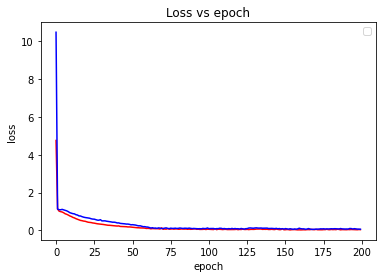

Train Class #: tensor([2260,  193])
Test Class #: tensor([1506,  130])


99.5842504279775

<Figure size 432x288 with 0 Axes>

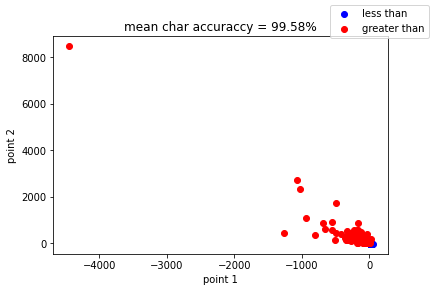

torch.Size([4089, 11])

Train Loss: 0.033	Test Loss: 0.090: 100%|██████████| 200/200 [00:07<00:00, 25.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024b55fd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0250fded0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


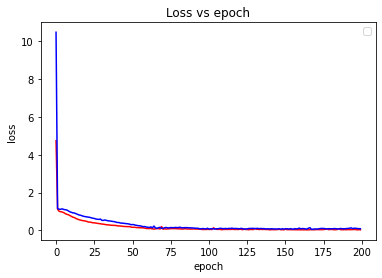

Train Class #: tensor([2260,  193])
Test Class #: tensor([1507,  129])


99.55979457079971

<Figure size 432x288 with 0 Axes>

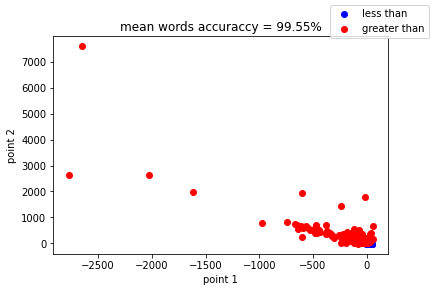

torch.Size([4089, 11])

Train Loss: 0.016	Test Loss: 0.051: 100%|██████████| 200/200 [00:06<00:00, 28.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0249ae490>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026858950>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


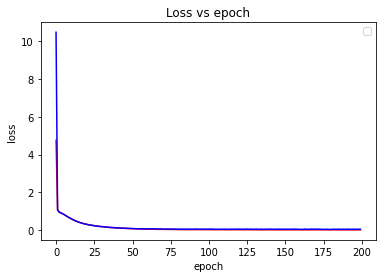

Train Class #: tensor([2247,  206])
Test Class #: tensor([1486,  150])


99.77989728539985

<Figure size 432x288 with 0 Axes>

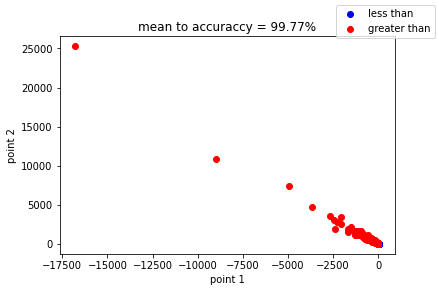

torch.Size([4089, 11])

Train Loss: 0.016	Test Loss: 0.051: 100%|██████████| 200/200 [00:08<00:00, 23.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0257c96d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024ef5f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


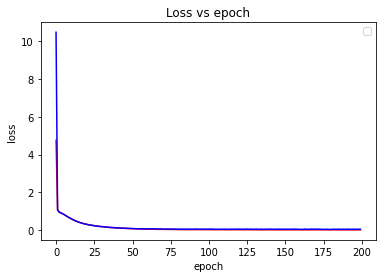

Train Class #: tensor([2247,  206])
Test Class #: tensor([1486,  150])


99.77989728539985

<Figure size 432x288 with 0 Axes>

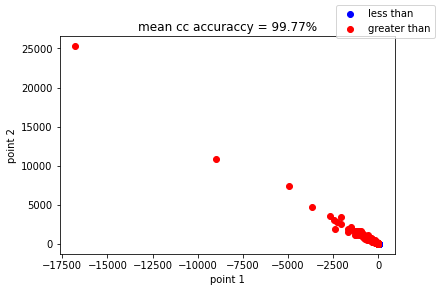

torch.Size([4089, 11])

Train Loss: 0.035	Test Loss: 0.068: 100%|██████████| 200/200 [00:07<00:00, 26.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026844f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024961490>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


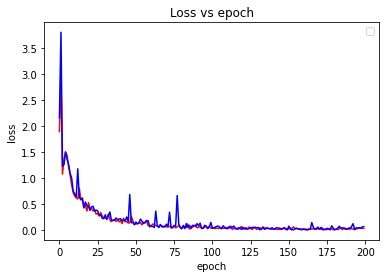

Train Class #: tensor([2382,   71])
Test Class #: tensor([1596,   40])


99.85326485693324

<Figure size 432x288 with 0 Axes>

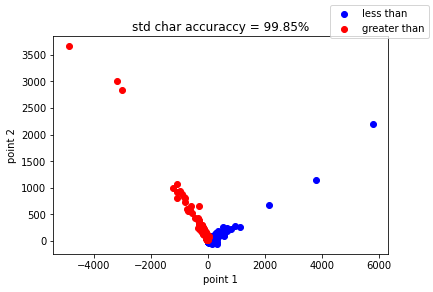

torch.Size([4089, 11])

Train Loss: 0.038	Test Loss: 0.044: 100%|██████████| 200/200 [00:06<00:00, 30.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024961690>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02546a090>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


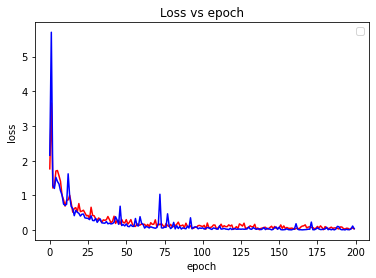

Train Class #: tensor([2381,   72])
Test Class #: tensor([1596,   40])


99.90217657128882

<Figure size 432x288 with 0 Axes>

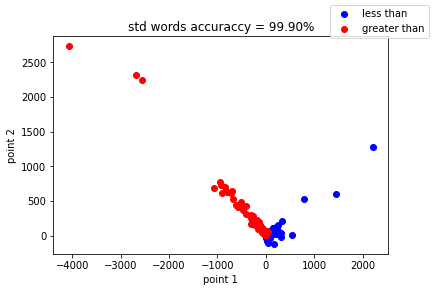

torch.Size([4089, 11])

Train Loss: 0.098	Test Loss: 0.138: 100%|██████████| 200/200 [00:06<00:00, 30.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026343b50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc025492190>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


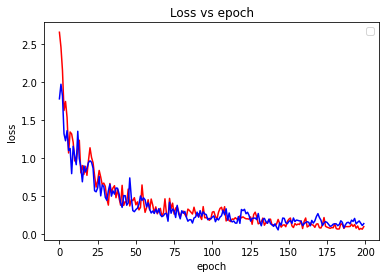

Train Class #: tensor([2411,   42])
Test Class #: tensor([1619,   17])


99.02176571288824

<Figure size 432x288 with 0 Axes>

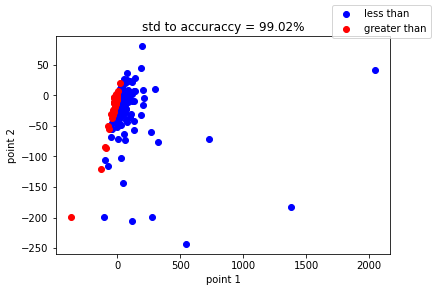

torch.Size([4089, 11])

Train Loss: 0.082	Test Loss: 0.122: 100%|██████████| 200/200 [00:05<00:00, 35.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc025dabe50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02491bf90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


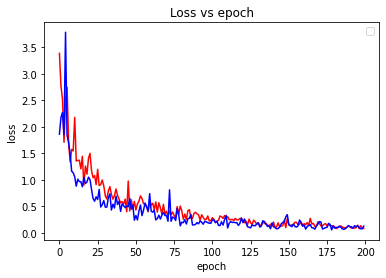

Train Class #: tensor([2414,   39])
Test Class #: tensor([1612,   24])


98.67938371239912

<Figure size 432x288 with 0 Axes>

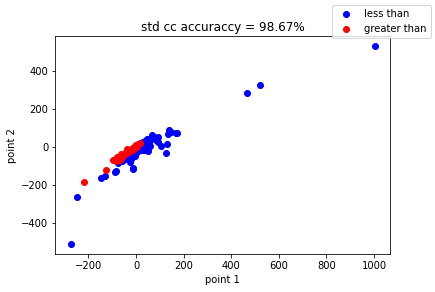

torch.Size([4089, 11])

Train Loss: 0.016	Test Loss: 0.051: 100%|██████████| 200/200 [00:06<00:00, 31.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc025d00e90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026b7f110>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


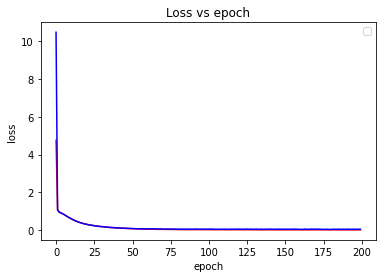

Train Class #: tensor([2247,  206])
Test Class #: tensor([1486,  150])


99.77989728539985

<Figure size 432x288 with 0 Axes>

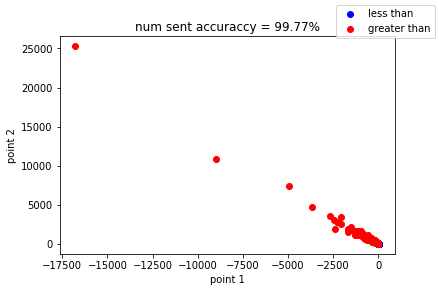

torch.Size([4089, 11])

Train Loss: 0.157	Test Loss: 0.275: 100%|██████████| 200/200 [00:05<00:00, 34.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02473a790>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0261b3e10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


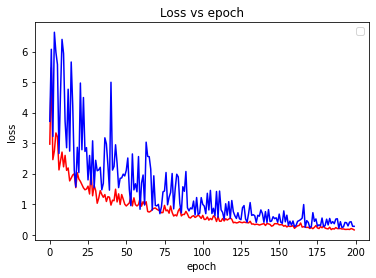

Train Class #: tensor([1984,  469])
Test Class #: tensor([1278,  358])


97.28539985326486

<Figure size 432x288 with 0 Axes>

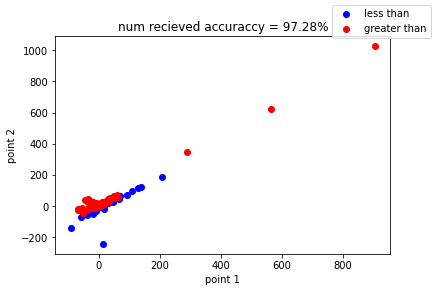

In [119]:
#this is meant to generate results for the original methods

titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test, df_node_meta_test, bi_classes_test[i])
  create_edges_txt(df_edges_test)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='none')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  #trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


torch.Size([4089, 11])

Train Loss: 0.032	Test Loss: 0.044: 100%|██████████| 200/200 [00:05<00:00, 36.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02473a4d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc025dceb50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


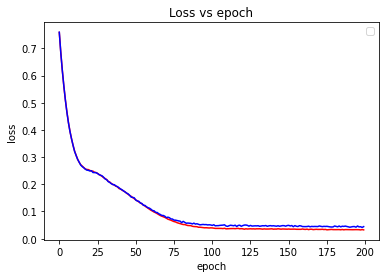

Train Class #: tensor([3012,  259])
Test Class #: tensor([754,  64])


99.21741257031059

<Figure size 432x288 with 0 Axes>

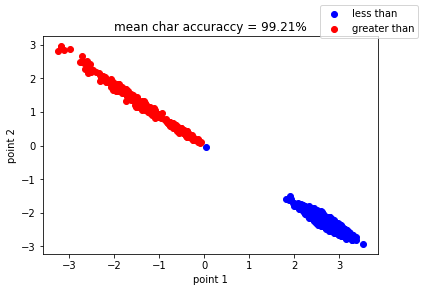

torch.Size([4089, 11])

Train Loss: 0.033	Test Loss: 0.046: 100%|██████████| 200/200 [00:05<00:00, 36.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0245c8850>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024967e10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


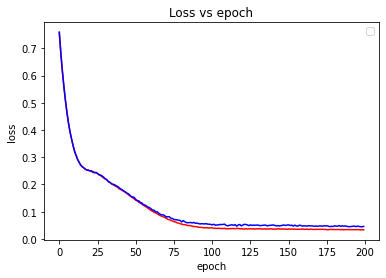

Train Class #: tensor([3013,  258])
Test Class #: tensor([754,  64])


99.1929567131328

<Figure size 432x288 with 0 Axes>

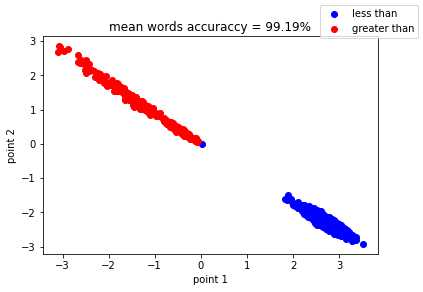

torch.Size([4089, 11])

Train Loss: 0.010	Test Loss: 0.010: 100%|██████████| 200/200 [00:07<00:00, 28.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0273b5f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02493bd90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


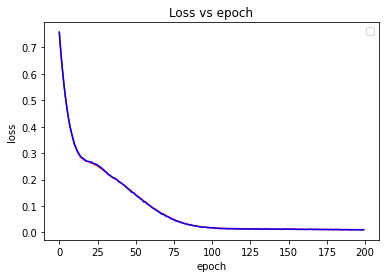

Train Class #: tensor([2987,  284])
Test Class #: tensor([746,  72])


100.0

<Figure size 432x288 with 0 Axes>

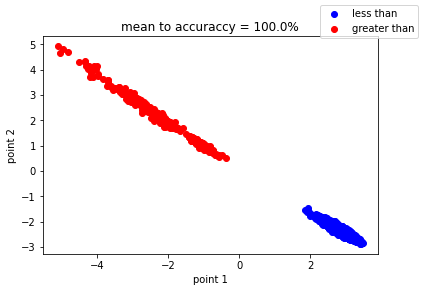

torch.Size([4089, 11])

Train Loss: 0.010	Test Loss: 0.010: 100%|██████████| 200/200 [00:08<00:00, 24.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02491bf90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024ef5cd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


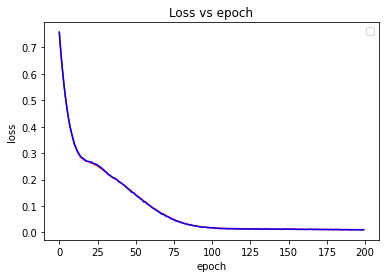

Train Class #: tensor([2987,  284])
Test Class #: tensor([746,  72])


100.0

<Figure size 432x288 with 0 Axes>

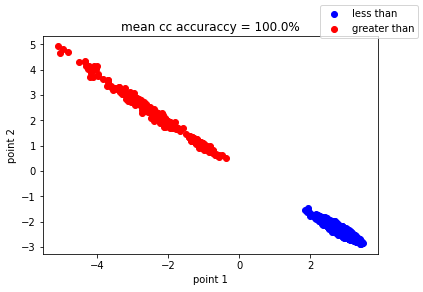

torch.Size([4089, 11])

Train Loss: 0.050	Test Loss: 0.039: 100%|██████████| 200/200 [00:07<00:00, 27.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0229f8710>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0245be890>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


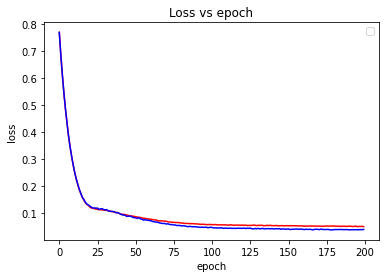

Train Class #: tensor([3183,   88])
Test Class #: tensor([795,  23])


98.60601614086573

<Figure size 432x288 with 0 Axes>

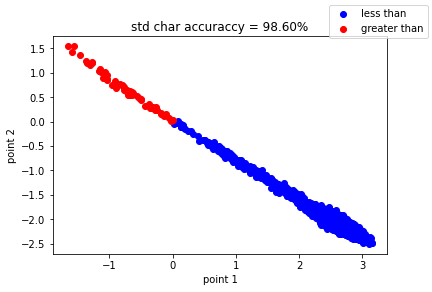

torch.Size([4089, 11])

Train Loss: 0.051	Test Loss: 0.036: 100%|██████████| 200/200 [00:07<00:00, 27.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026784a10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02580a350>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


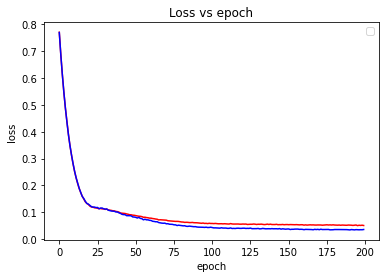

Train Class #: tensor([3182,   89])
Test Class #: tensor([795,  23])


98.60601614086573

<Figure size 432x288 with 0 Axes>

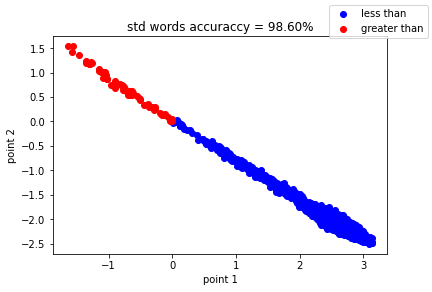

torch.Size([4089, 11])

Train Loss: 0.016	Test Loss: 0.016: 100%|██████████| 200/200 [00:07<00:00, 26.79it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02499df10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026900250>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


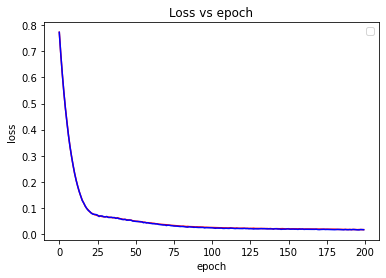

Train Class #: tensor([3224,   47])
Test Class #: tensor([806,  12])


99.51088285644411

<Figure size 432x288 with 0 Axes>

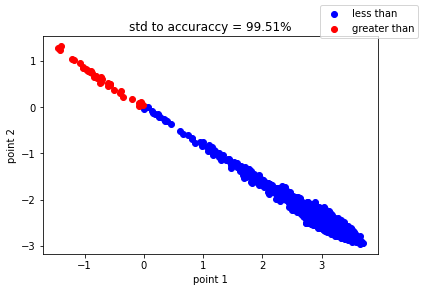

torch.Size([4089, 11])

Train Loss: 0.014	Test Loss: 0.015: 100%|██████████| 200/200 [00:07<00:00, 27.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc027418b50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0229c0910>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


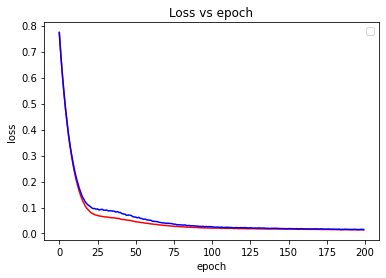

Train Class #: tensor([3225,   46])
Test Class #: tensor([801,  17])


99.5842504279775

<Figure size 432x288 with 0 Axes>

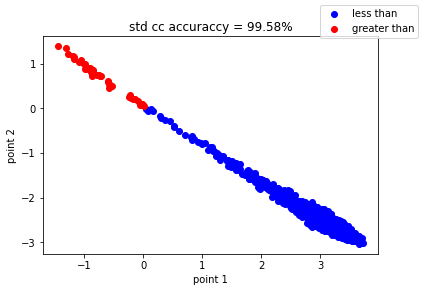

torch.Size([4089, 11])

Train Loss: 0.010	Test Loss: 0.010: 100%|██████████| 200/200 [00:07<00:00, 27.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024b6cd10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc025113150>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


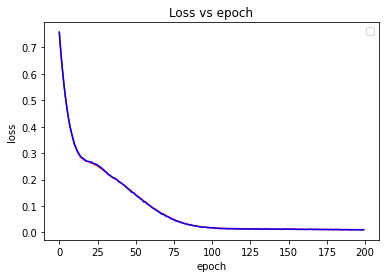

Train Class #: tensor([2987,  284])
Test Class #: tensor([746,  72])


100.0

<Figure size 432x288 with 0 Axes>

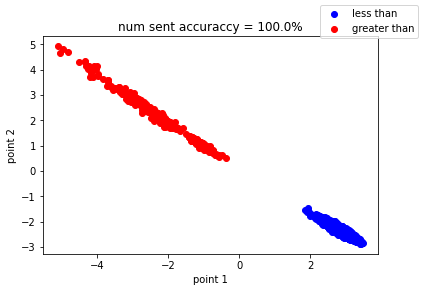

torch.Size([4089, 11])

Train Loss: 0.221	Test Loss: 0.234: 100%|██████████| 200/200 [00:05<00:00, 34.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0257c7f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0247528d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


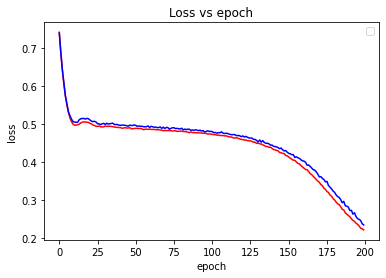

Train Class #: tensor([2613,  658])
Test Class #: tensor([649, 169])


91.07361213010516

<Figure size 432x288 with 0 Axes>

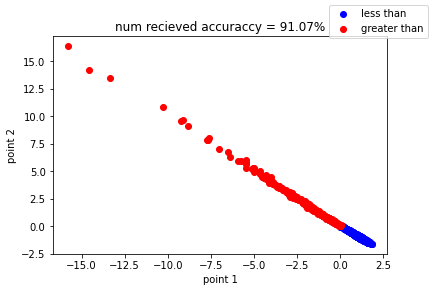

In [122]:
#this is meant to generate results for the email data set with scaled attributes


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test, scaled_df_node_meta_test, bi_classes_test_scaled[i])
  create_edges_txt(df_edges_test)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='none')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test_scaled[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


torch.Size([4080, 11])

Train Loss: 0.035	Test Loss: 0.052: 100%|██████████| 200/200 [00:10<00:00, 19.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026331ed0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024739d50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


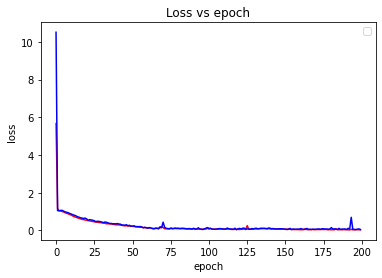

Train Class #: tensor([3004,  260])
Test Class #: tensor([753,  63])


99.58333333333333

<Figure size 432x288 with 0 Axes>

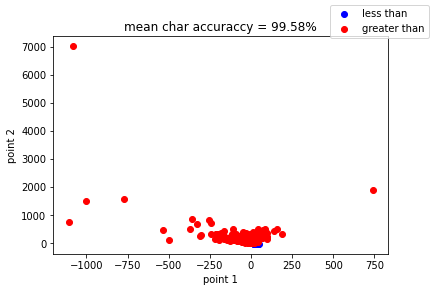

torch.Size([4080, 11])

Train Loss: 0.052	Test Loss: 0.061: 100%|██████████| 200/200 [00:05<00:00, 33.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026dd18d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0262ab750>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


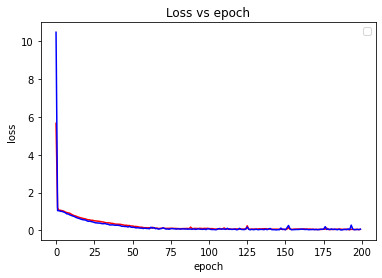

Train Class #: tensor([3006,  258])
Test Class #: tensor([752,  64])


99.50980392156863

<Figure size 432x288 with 0 Axes>

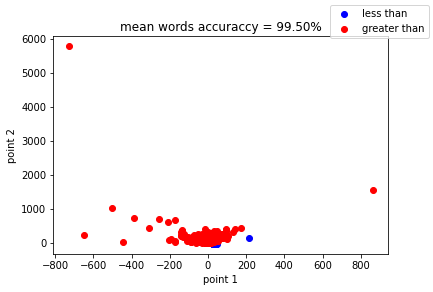

torch.Size([4080, 11])

Train Loss: 0.009	Test Loss: 0.072: 100%|██████████| 200/200 [00:05<00:00, 36.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc025474b10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0262d17d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


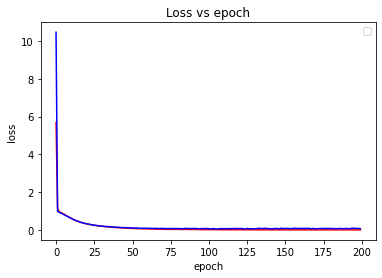

Train Class #: tensor([2985,  279])
Test Class #: tensor([747,  69])


99.95098039215686

<Figure size 432x288 with 0 Axes>

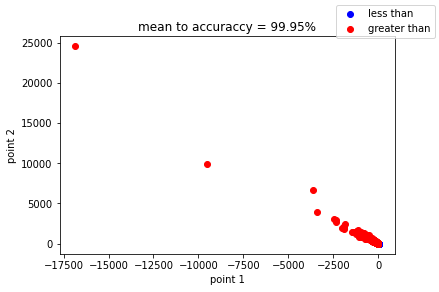

torch.Size([4080, 11])

Train Loss: 0.009	Test Loss: 0.072: 100%|██████████| 200/200 [00:05<00:00, 36.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026417390>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026844750>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


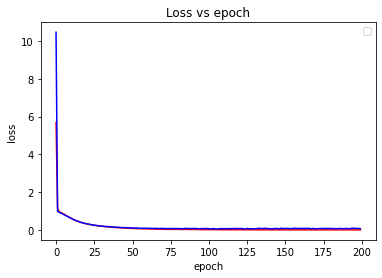

Train Class #: tensor([2985,  279])
Test Class #: tensor([747,  69])


99.95098039215686

<Figure size 432x288 with 0 Axes>

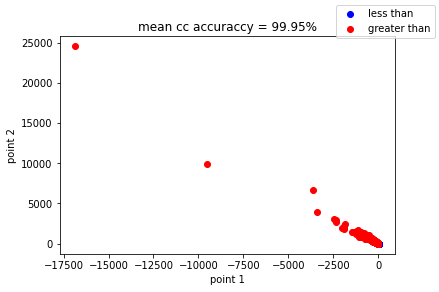

torch.Size([4080, 11])

Train Loss: 0.013	Test Loss: 0.078: 100%|██████████| 200/200 [00:06<00:00, 33.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0257d4ed0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024967110>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


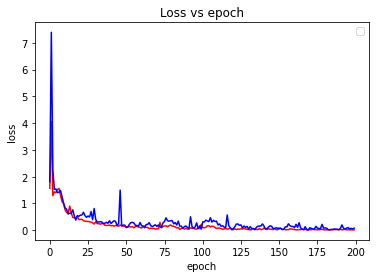

Train Class #: tensor([3180,   84])
Test Class #: tensor([793,  23])


99.90196078431373

<Figure size 432x288 with 0 Axes>

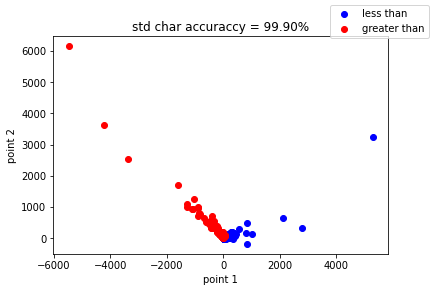

torch.Size([4080, 11])

Train Loss: 0.061	Test Loss: 0.059: 100%|██████████| 200/200 [00:05<00:00, 33.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0245c8f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc027418850>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


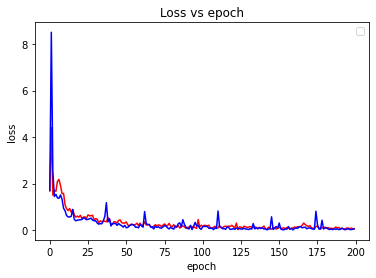

Train Class #: tensor([3177,   87])
Test Class #: tensor([794,  22])


99.63235294117646

<Figure size 432x288 with 0 Axes>

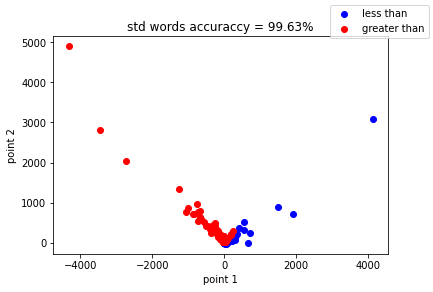

torch.Size([4080, 11])

Train Loss: 0.179	Test Loss: 0.040: 100%|██████████| 200/200 [00:05<00:00, 34.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0245c8b10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0263e1bd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


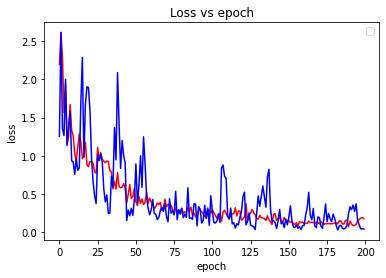

Train Class #: tensor([3218,   46])
Test Class #: tensor([805,  11])


99.04411764705883

<Figure size 432x288 with 0 Axes>

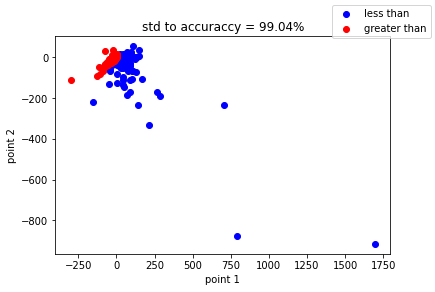

torch.Size([4080, 11])

Train Loss: 0.081	Test Loss: 0.314: 100%|██████████| 200/200 [00:05<00:00, 34.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc022b45550>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0274186d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


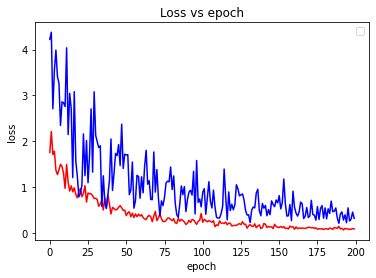

Train Class #: tensor([3214,   50])
Test Class #: tensor([803,  13])


98.72549019607843

<Figure size 432x288 with 0 Axes>

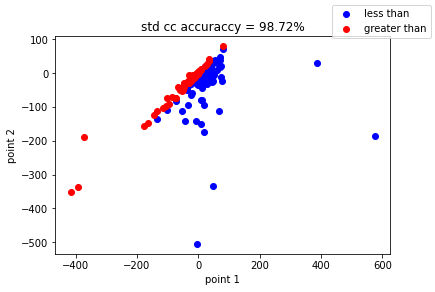

torch.Size([4080, 11])

Train Loss: 0.009	Test Loss: 0.072: 100%|██████████| 200/200 [00:05<00:00, 34.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026900d50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024bfb490>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


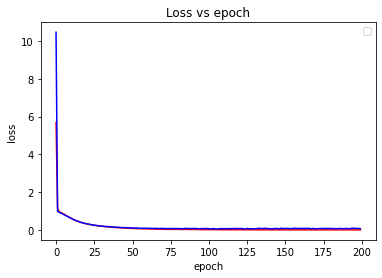

Train Class #: tensor([2985,  279])
Test Class #: tensor([747,  69])


99.95098039215686

<Figure size 432x288 with 0 Axes>

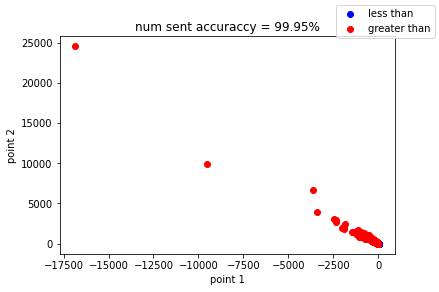

torch.Size([4080, 11])

Train Loss: 0.327	Test Loss: 1.500: 100%|██████████| 200/200 [00:05<00:00, 34.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024b6cfd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc025818090>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


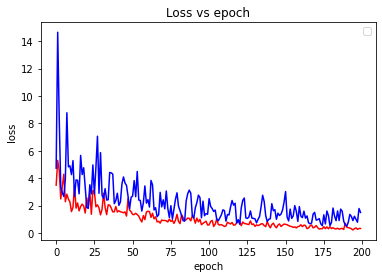

Train Class #: tensor([2625,  639])
Test Class #: tensor([629, 187])


95.80882352941177

<Figure size 432x288 with 0 Axes>

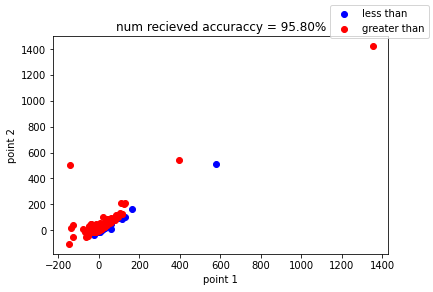

In [124]:
#this is meant to generate results for the email dataset with the char and word outliers removed


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test_wo_outliers, df_node_meta_test_wo_outliers, bi_classes_test_wo_outliers[i])
  create_edges_txt(df_edges_test_wo_outliers)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='none')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test_wo_outliers[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


torch.Size([4080, 11])

Train Loss: 0.031	Test Loss: 0.030: 100%|██████████| 200/200 [00:05<00:00, 37.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0273b7b50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026331190>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


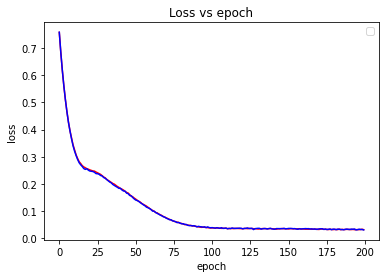

Train Class #: tensor([3004,  260])
Test Class #: tensor([753,  63])


99.38725490196079

<Figure size 432x288 with 0 Axes>

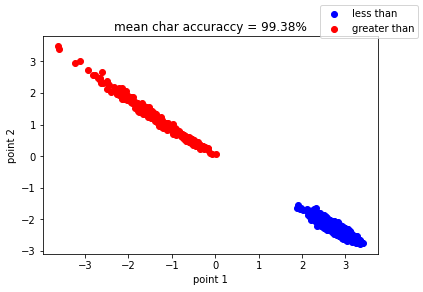

torch.Size([4080, 11])

Train Loss: 0.033	Test Loss: 0.028: 100%|██████████| 200/200 [00:05<00:00, 38.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026340cd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024e82250>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


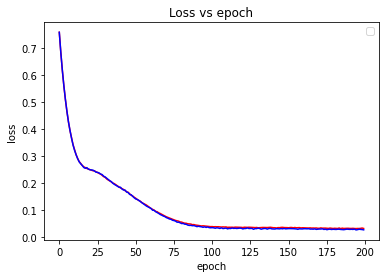

Train Class #: tensor([3006,  258])
Test Class #: tensor([752,  64])


99.36274509803921

<Figure size 432x288 with 0 Axes>

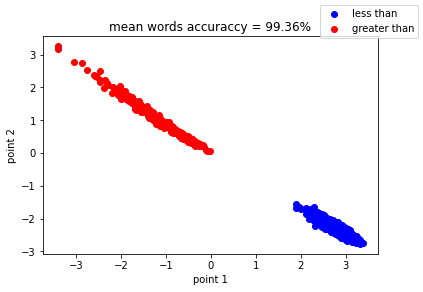

torch.Size([4080, 11])

Train Loss: 0.010	Test Loss: 0.011: 100%|██████████| 200/200 [00:05<00:00, 37.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02625f150>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0257df650>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


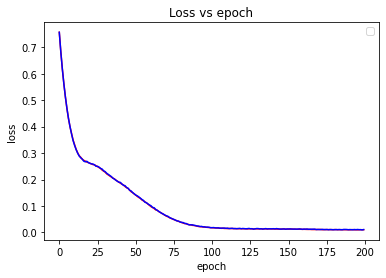

Train Class #: tensor([2985,  279])
Test Class #: tensor([747,  69])


100.0

<Figure size 432x288 with 0 Axes>

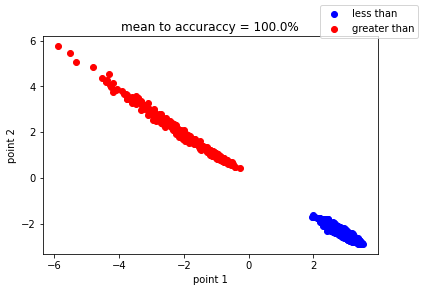

torch.Size([4080, 11])

Train Loss: 0.010	Test Loss: 0.011: 100%|██████████| 200/200 [00:05<00:00, 37.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02625f250>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0262a4d90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


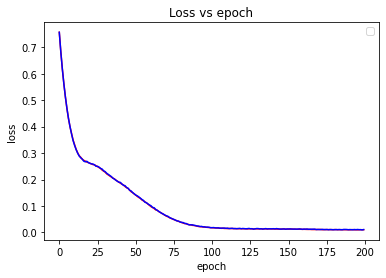

Train Class #: tensor([2985,  279])
Test Class #: tensor([747,  69])


100.0

<Figure size 432x288 with 0 Axes>

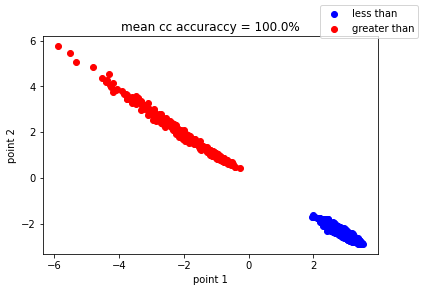

torch.Size([4080, 11])

Train Loss: 0.045	Test Loss: 0.054: 100%|██████████| 200/200 [00:05<00:00, 37.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc025db01d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024731e50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


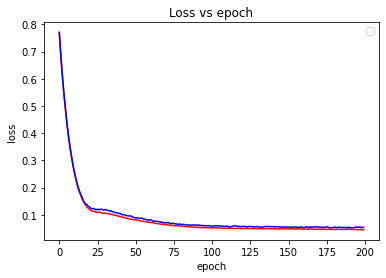

Train Class #: tensor([3180,   84])
Test Class #: tensor([793,  23])


98.65196078431373

<Figure size 432x288 with 0 Axes>

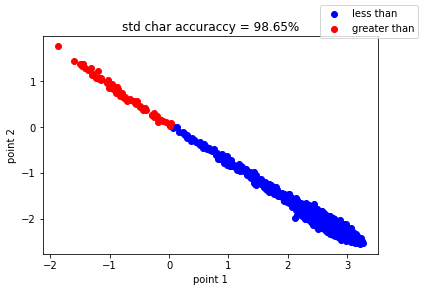

torch.Size([4080, 11])

Train Loss: 0.045	Test Loss: 0.049: 100%|██████████| 200/200 [00:05<00:00, 36.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02633bd90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026844490>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


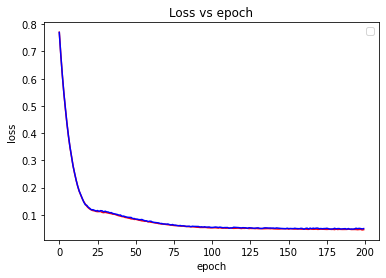

Train Class #: tensor([3177,   87])
Test Class #: tensor([794,  22])


98.72549019607843

<Figure size 432x288 with 0 Axes>

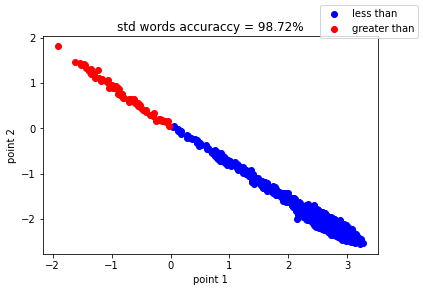

torch.Size([4080, 11])

Train Loss: 0.017	Test Loss: 0.018: 100%|██████████| 200/200 [00:05<00:00, 36.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026844210>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02509c590>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


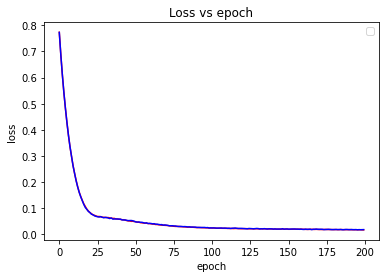

Train Class #: tensor([3218,   46])
Test Class #: tensor([805,  11])


99.43627450980392

<Figure size 432x288 with 0 Axes>

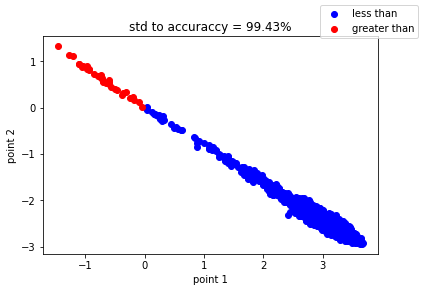

torch.Size([4080, 11])

Train Loss: 0.013	Test Loss: 0.015: 100%|██████████| 200/200 [00:05<00:00, 36.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc024b1ef50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026900a90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


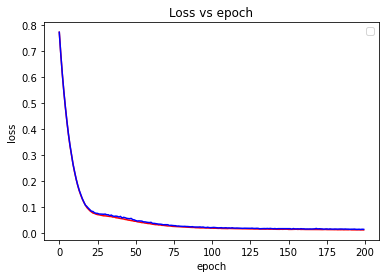

Train Class #: tensor([3214,   50])
Test Class #: tensor([803,  13])


99.58333333333333

<Figure size 432x288 with 0 Axes>

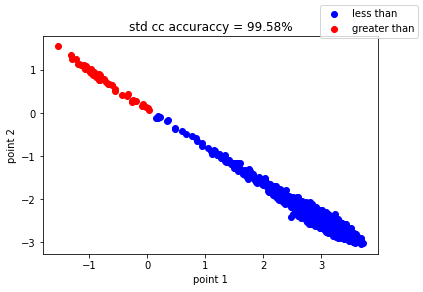

torch.Size([4080, 11])

Train Loss: 0.010	Test Loss: 0.011: 100%|██████████| 200/200 [00:05<00:00, 36.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02493b210>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc026d58810>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


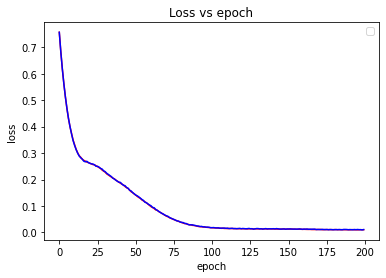

Train Class #: tensor([2985,  279])
Test Class #: tensor([747,  69])


100.0

<Figure size 432x288 with 0 Axes>

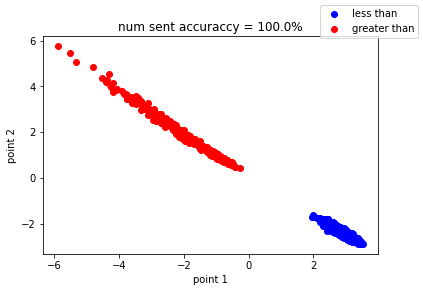

torch.Size([4080, 11])

Train Loss: 0.200	Test Loss: 0.246: 100%|██████████| 200/200 [00:05<00:00, 35.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc02455eed0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc0262a14d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


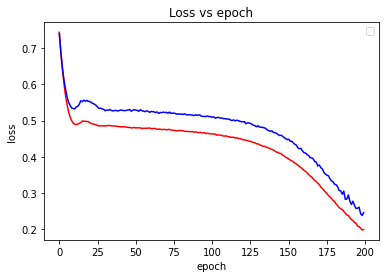

Train Class #: tensor([2625,  639])
Test Class #: tensor([629, 187])


91.12745098039215

<Figure size 432x288 with 0 Axes>

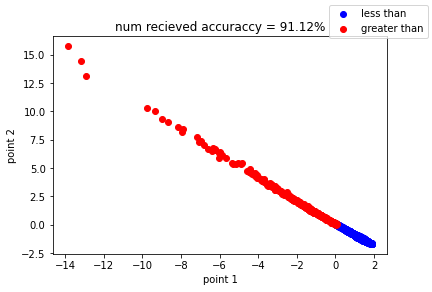

In [125]:
#this is meant to generate results for the email dataset with outliers removed and the attributes scaled


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test_wo_outliers, scaled_df_node_meta_test_wo_outliers, bi_classes_test_wo_outliers_scaled[i])
  create_edges_txt(df_edges_test_wo_outliers)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='none')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test_wo_outliers_scaled[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


In [126]:
#this is meant to generate results for the original methods 
#I am repeating this to demonstrate the error with regards to the aggregation function

titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test, df_node_meta_test, bi_classes_test[i])
  create_edges_txt(df_edges_test)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='mean')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  #trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()l

SyntaxError: ignored

In [120]:
#this is meant to generate results for the email dataset with the char and word outliers removed


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test_wo_outliers, df_node_meta_test_wo_outliers, bi_classes_test_wo_outliers[i])
  create_edges_txt(df_edges_test_wo_outliers)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='mean')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test_wo_outliers[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  

torch.Size([4080, 11])

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: ignored